In [415]:
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.datasets import load_digits
from scipy.io import arff

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression

import pydotplus
import numpy as np
import pandas as pd
import networkx as nx
import operator

import matplotlib.pyplot as plt
import seaborn as sns

### Dataset preparation

In [2]:
def standarize_datasets(all_data,train_x,test_x):
    scaler = StandardScaler()
    scaler.fit(all_data)
    return scaler.transform(train_x), scaler.transform(test_x)

In [3]:
train_ds = pd.read_csv('dataset/diatoms_train.csv', header=None)
test_ds = pd.read_csv('dataset/diatoms_test.csv', header=None)

In [4]:
merged=pd.concat([train_ds,test_ds])

In [5]:
train_ds_y=train_ds[372]
train_ds_x= train_ds.drop(372, 1)
test_ds_y=test_ds[372]
test_ds_x= test_ds.drop(372, 1)
merged_y=merged[372]
merged_x= merged.drop(372, 1)

In [6]:
train_ds_x_std,test_ds_x_std=standarize_datasets(merged_x,train_ds_x,test_ds_x)

In [7]:
def visualize_data_stats(labels): 
    unique_labels=list(set(labels.to_list()))
    classes_dict={}
    for label in unique_labels: 
        classes_dict[label]=0
    for elem in labels.to_list():
        classes_dict[elem]=classes_dict[elem]+1
    sorted_classes_dict = dict(sorted(classes_dict.items(), key=operator.itemgetter(1),reverse=True))
    keys=list(sorted_classes_dict.keys())
    values=list(sorted_classes_dict.values())
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(keys,values)
    plt.show()
    print('CLASSES COUNT: {0}'.format(len(unique_labels)))
    print('CLASSES DISTRIBUTION: {0}'.format(sorted_classes_dict))
    return sorted_classes_dict

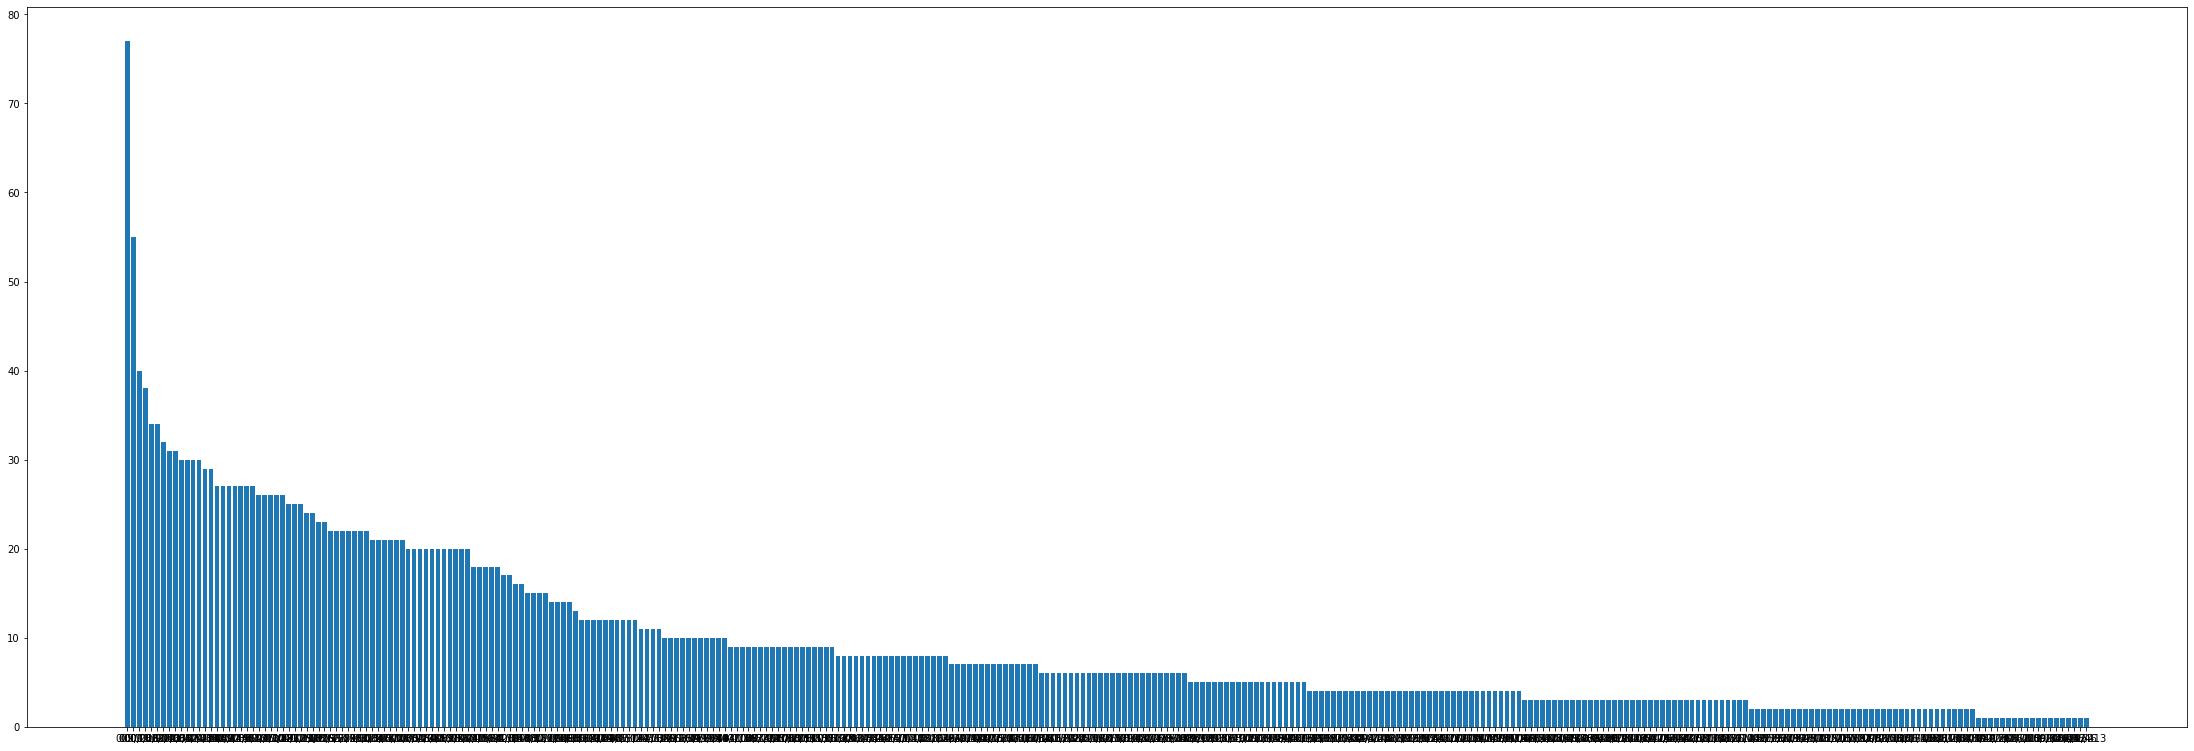

CLASSES COUNT: 329
CLASSES DISTRIBUTION: {'000': 77, '009/11': 55, '000/026': 40, '000/187': 38, '028/90': 34, '006/07': 34, '022/40': 32, '027/63': 31, '002/68': 31, '001/52': 30, '008/154': 30, '001/121': 30, '042/104': 30, '004/100': 29, '001/120': 29, '035/47': 27, '000/72': 27, '046/115': 27, '009/145': 27, '014/82': 27, '008/252': 27, '000/131': 27, '007/17': 26, '050/132': 26, '040/101': 26, '007/49': 26, '19/181': 26, '000/62': 25, '000/25': 25, '027/168': 25, '000/02': 24, '023/70': 24, '19/115': 23, '008/95': 23, '002/157': 22, '026/251': 22, '066/195': 22, '023/272': 22, '020/30': 22, '033/08': 22, '003/04': 22, '000/105': 21, '023/75': 21, '023/270': 21, '000/10': 21, '002/271': 21, '000/00': 21, '006/33': 20, '007/213': 20, '083/266': 20, '004/265': 20, '026/213': 20, '084/269': 20, '018/23': 20, '008/267': 20, '009/268': 20, '007/71': 20, '013/41': 20, '042/106': 18, '000/113': 18, '000/54': 18, '19/94': 18, '052/135': 18, '021/81': 17, '042/246': 17, '000/108': 16, '010'

In [8]:
sorted_classes_dict=visualize_data_stats(merged_y)

In [12]:
def filter_weakly_supported_labels(all_ds,all_lables_dict,threshold=15):
    well_supported=[]
    for key in all_lables_dict.keys():
        if all_lables_dict[key] >=threshold:
            well_supported.append(key)
    all_ds=all_ds[all_ds[372].isin(well_supported)]
    all_y=all_ds[372]
    all_x= all_ds.drop(372, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(
        all_x,
        all_y,
        test_size=0.2,
        random_state=42,
    )
    return all_x,all_y,X_train, X_test, y_train, y_test

In [13]:
merged_x,merged_y,train_ds_x,test_ds_x,train_ds_y,test_ds_y=filter_weakly_supported_labels(merged,sorted_classes_dict)

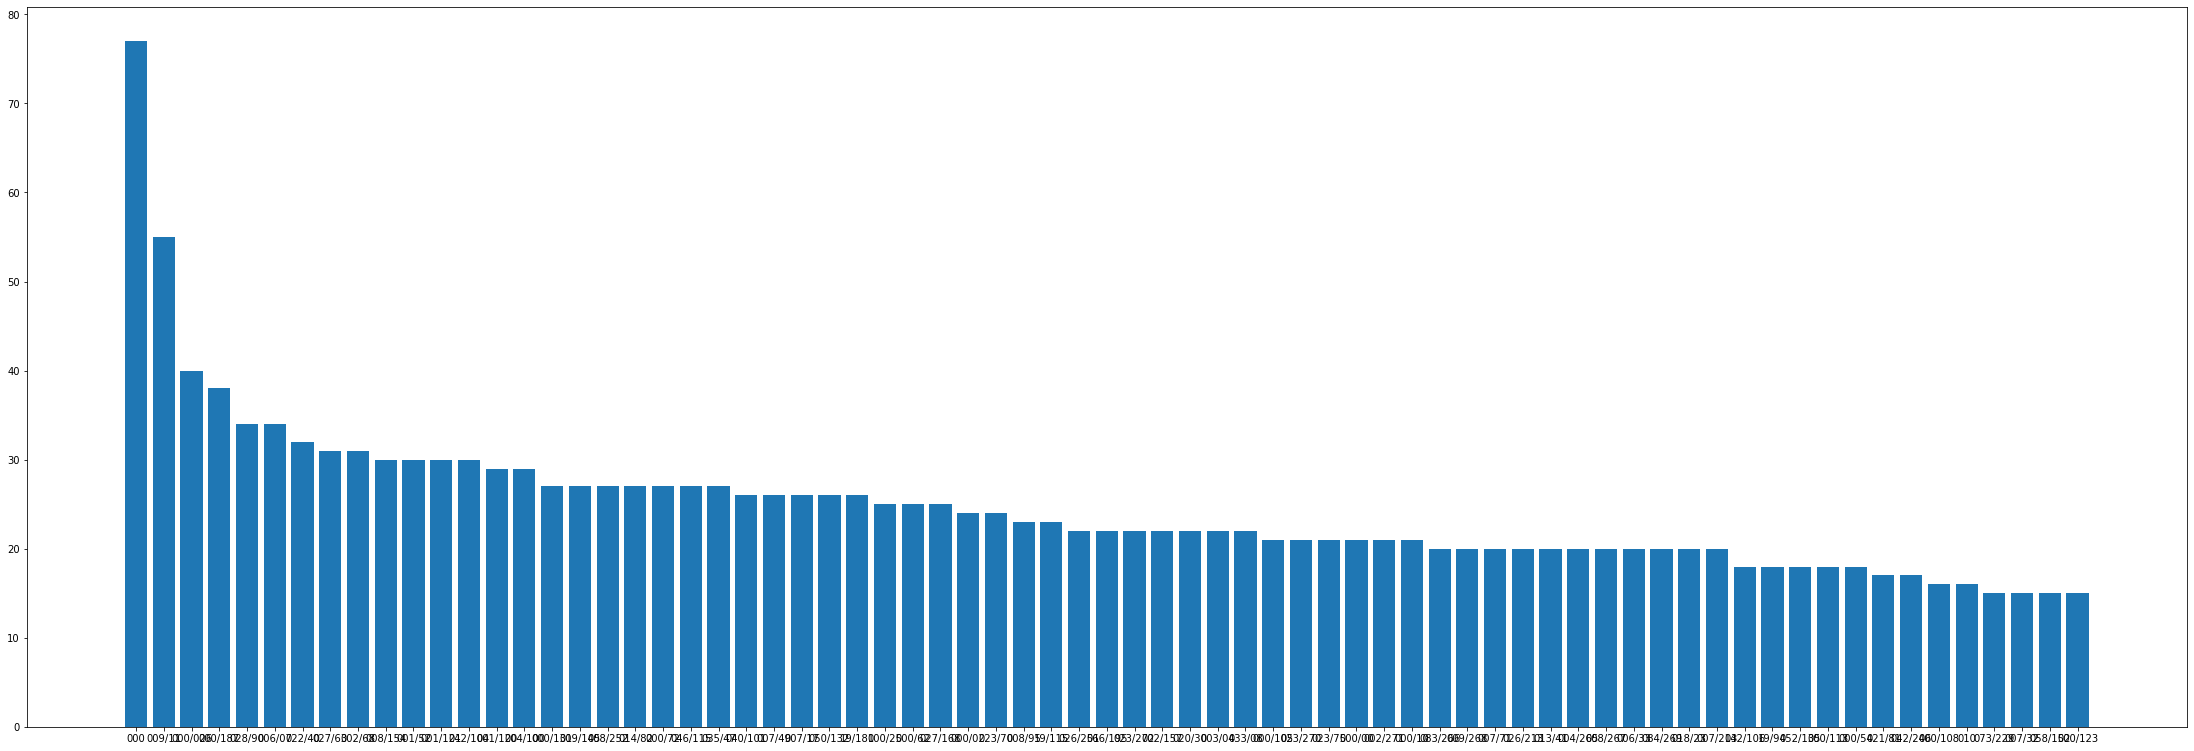

CLASSES COUNT: 71
CLASSES DISTRIBUTION: {'000': 77, '009/11': 55, '000/026': 40, '000/187': 38, '028/90': 34, '006/07': 34, '022/40': 32, '027/63': 31, '002/68': 31, '008/154': 30, '001/52': 30, '001/121': 30, '042/104': 30, '001/120': 29, '004/100': 29, '000/131': 27, '009/145': 27, '008/252': 27, '014/82': 27, '000/72': 27, '046/115': 27, '035/47': 27, '040/101': 26, '007/49': 26, '007/17': 26, '050/132': 26, '19/181': 26, '000/25': 25, '000/62': 25, '027/168': 25, '000/02': 24, '023/70': 24, '008/95': 23, '19/115': 23, '026/251': 22, '066/195': 22, '023/272': 22, '002/157': 22, '020/30': 22, '003/04': 22, '033/08': 22, '000/105': 21, '023/270': 21, '023/75': 21, '000/00': 21, '002/271': 21, '000/10': 21, '083/266': 20, '009/268': 20, '007/71': 20, '026/213': 20, '013/41': 20, '004/265': 20, '008/267': 20, '006/33': 20, '084/269': 20, '018/23': 20, '007/213': 20, '042/106': 18, '19/94': 18, '052/135': 18, '000/113': 18, '000/54': 18, '021/81': 17, '042/246': 17, '000/108': 16, '010':

In [14]:
sorted_classes_dict=visualize_data_stats(merged_y)

## PART I - flat classification vs hierarchical

### Flat classifiers 

In [15]:
def svm_classifier(x_train,y_train):
    clf = svm.SVC()
    clf.fit(x_train, y_train)
    return clf

In [16]:
def naive_bayes_classifier(x_train,y_train):
    clf = GaussianNB()
    clf.fit(x_train,y_train)
    return clf

In [17]:
def mlp_classifier(x_train,y_train):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(100, 2), random_state=1)
    clf.fit(x_train,y_train)
    return clf

In [18]:
def decision_tree_classifier(x_train,y_train):
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(x_train,y_train)
    return clf

In [19]:
def random_forrest_classifier(x_train,y_train):
    clf = RandomForestClassifier(random_state=0)
    clf.fit(x_train,y_train)
    return clf

In [20]:
# clf=random_forrest_classifier(train_ds_x,train_ds_y)
# res=clf.predict(test_ds_x)
# print(f1_score(test_ds_y, res,average='macro'))
# print(accuracy_score(test_ds_y, res))

In [22]:
def run_tests_flat(file_name):
    DF_COLUMNS = ['CLASSIFIER','F1','ACC']
    CLASSIFIERS=[random_forrest_classifier,decision_tree_classifier,mlp_classifier,naive_bayes_classifier,svm_classifier]
    CLASSIFIERS_LABELS=['random forrest','decision tree','mlp','NB','SVM']


    df = pd.DataFrame(columns=DF_COLUMNS)
    df.to_csv(file_name + '.csv',index=False)
    
    for classifier in CLASSIFIERS:
        classifier_desc=CLASSIFIERS_LABELS[CLASSIFIERS.index(classifier)]
        clf=classifier(train_ds_x,train_ds_y)
        res=clf.predict(test_ds_x)
        f1=f1_score(test_ds_y, res,average='macro')
        acc=accuracy_score(test_ds_y, res)
        subdf=pd.DataFrame(zip([classifier_desc],[f1],[acc]),
                           columns=DF_COLUMNS)
        subdf.to_csv(file_name + '.csv', mode='a',
                     header=False, index=False)

In [24]:
# run_tests_flat('flat_classifiers')

In [25]:
flat_results = pd.read_csv('flat_classifiers.csv')

In [26]:
flat_results.sort_values(by=['F1'], ascending=False)

,CLASSIFIER,F1,ACC
0,random forrest,0.605443,0.623932
1,decision tree,0.476679,0.475783
3,NB,0.309032,0.344729
2,mlp,0.000931,0.034188
4,SVM,0.000931,0.034188


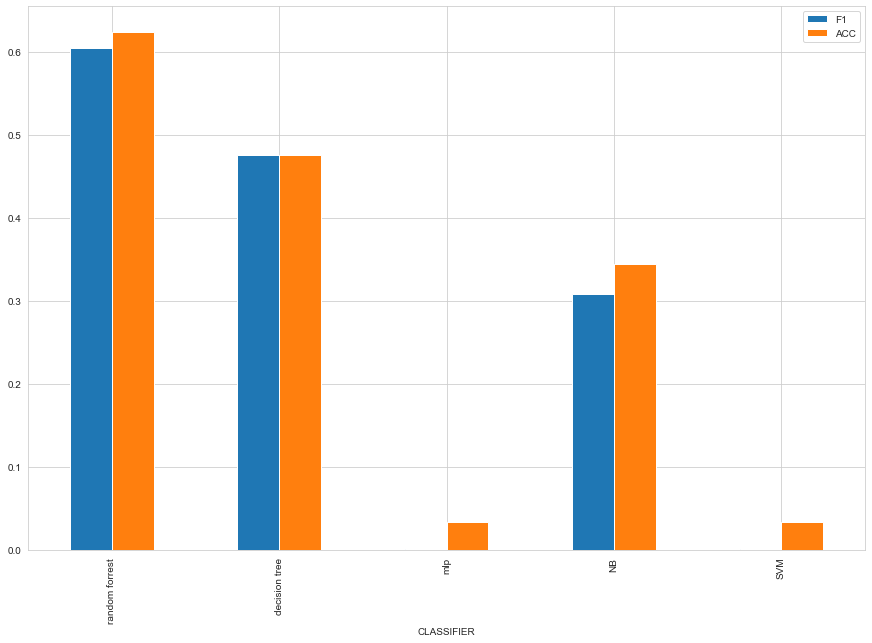

In [27]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(15,10))
flat_results.plot.bar(ax=ax,x='CLASSIFIER')

### Hierarchical classifier

In [28]:
def prepare_class_hierarchy(y_dataset):
    unique_labels=list(set(y_dataset.to_list()))
    level_1_leafs=[label for label in  unique_labels if '/' not in label]
    root_labels_with_children=[label.split('/')[0] for label in  unique_labels if '/'in label]
    root_labels=level_1_leafs+root_labels_with_children
    root_labels=list(set(root_labels))
    level_2_leafs=[label for label in  unique_labels if len(label.split('/')) ==2]
    level_3_leafs=[label for label in  unique_labels if len(label.split('/')) ==3]
    targets=level_1_leafs+level_2_leafs+level_3_leafs
    targets=list(set(targets))
    class_hierarchy={ROOT:root_labels}
    for label in unique_labels:
        class_hierarchy[label]=[]
    for label in level_2_leafs:
        parent=label.rsplit('/', 1)[0]
        if parent in class_hierarchy.keys():
            class_hierarchy[parent].append(label)
        else:
            class_hierarchy[parent]=[label]
    for label in level_3_leafs:
        parent=label.rsplit('/', 1)[0]
        if parent in class_hierarchy.keys():
            class_hierarchy[parent].append(label)
        else:
            class_hierarchy[parent]=[label]
    empty_keys=[key for key in class_hierarchy.keys() if class_hierarchy[key]==[]]
    for key in empty_keys:
        del class_hierarchy[key]
    return class_hierarchy

In [29]:
class_hierarchy=prepare_class_hierarchy(merged_y)

#### Adjust hierarchical measure 

In [54]:
def prepare_evaluation_graph(xs,ys):
    base_estimator = make_pipeline(
        ## ONLY FOR GRAPH CREATION
        RandomForestClassifier(random_state=0)
    )
    clf = HierarchicalClassifier(
        base_estimator=base_estimator,
        class_hierarchy=class_hierarchy,
    )

    clf.fit(xs,ys)
    return clf.graph_

EVAL_GRAPH=prepare_evaluation_graph(merged_x,merged_y)

def evaluate_h_f1(real,predicted):
    real_prep=[[elem] for elem in real.to_list()]
    predicted_prep=[[elem] for elem in list(predicted)]
    with multi_labeled(real_prep, predicted_prep, EVAL_GRAPH) as (y_test_, y_pred_, graph_):
        h_fbeta = h_fbeta_score(
            y_test_,
            y_pred_,
            graph_,
        )
    return h_fbeta

#### Visualize hierarchy

In [45]:
def visualize_hierarchy(graph):
    try:
        import pygraphviz
        from networkx.drawing.nx_agraph import graphviz_layout
    except ImportError:
        try:
            import pydot
            from networkx.drawing.nx_pydot import graphviz_layout
        except ImportError:
            raise ImportError("This example needs Graphviz and either "
                              "PyGraphviz or pydot")

    G = graph
    pos = graphviz_layout(G, prog='twopi', args='')
    plt.figure(figsize=(15, 15))
    nx.draw(G, pos, node_size=20, alpha=0.5, node_color="blue", with_labels=True)
    plt.axis('equal')
    plt.show()

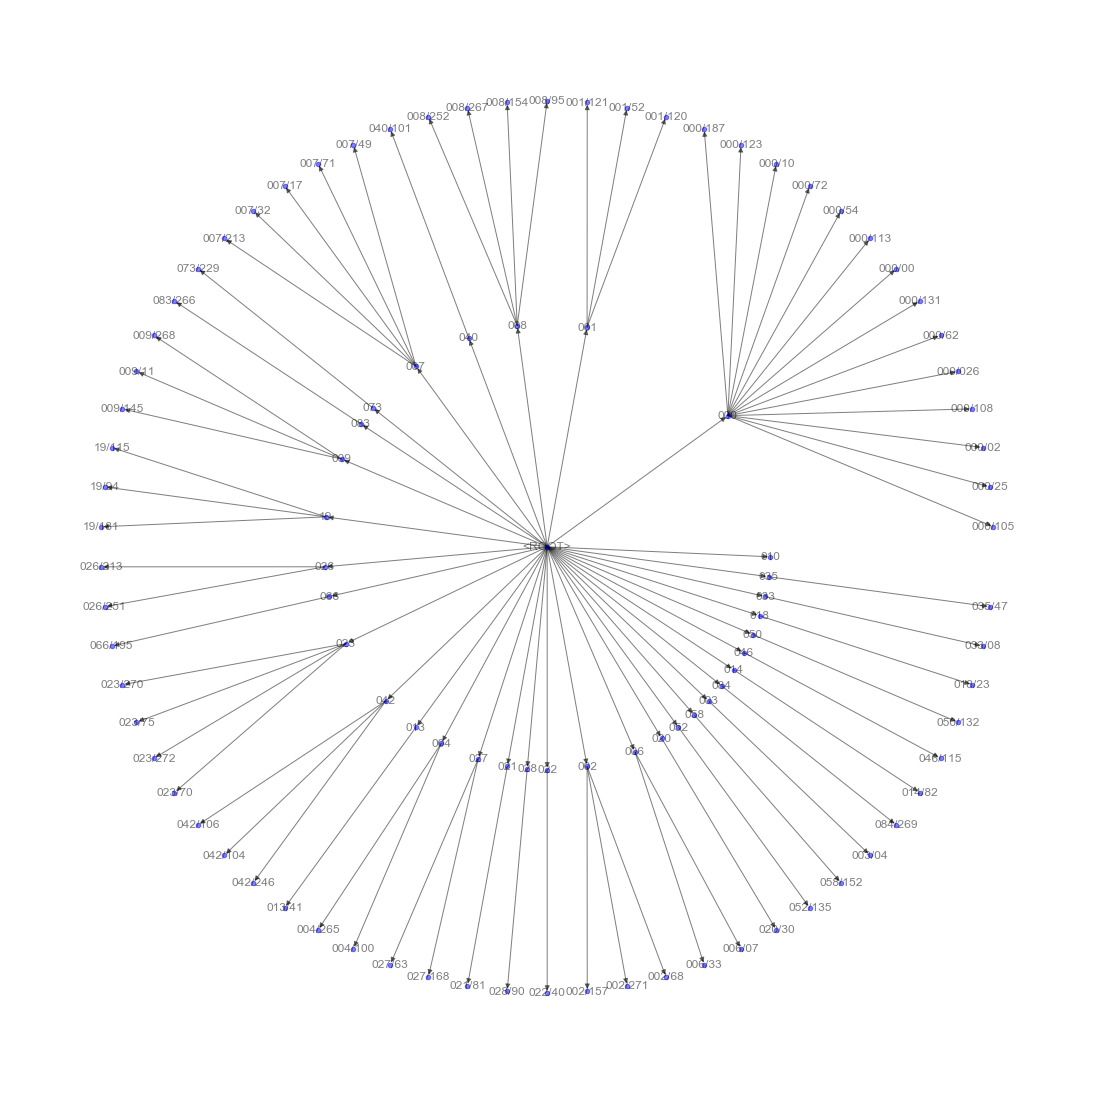

In [46]:
visualize_hierarchy(EVAL_GRAPH)

#### Hierarchical classifiers

In [47]:
def svn_hierarchical(train_xs,train_ys):
    base_estimator = make_pipeline(
        svm.SVC(probability=True)
    )
    clf = HierarchicalClassifier(
        base_estimator=base_estimator,
        class_hierarchy=class_hierarchy,
    )

    clf.fit(train_xs,train_ys)
    return clf

def random_forrest_hierarchical(train_xs,train_ys):
    base_estimator = make_pipeline(
        RandomForestClassifier(random_state=0)
    )
    clf = HierarchicalClassifier(
        base_estimator=base_estimator,
        class_hierarchy=class_hierarchy,
    )

    clf.fit(train_xs,train_ys)
    return clf

def decision_tree_hierarchical(train_xs,train_ys):
    base_estimator = make_pipeline(
        DecisionTreeClassifier(random_state=0)
    )
    clf = HierarchicalClassifier(
        base_estimator=base_estimator,
        class_hierarchy=class_hierarchy,
    )

    clf.fit(train_xs,train_ys)
    return clf

def mlp_hierarchical(train_xs,train_ys):
    base_estimator = make_pipeline(
        MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(100, 2), random_state=1)
    )
    clf = HierarchicalClassifier(
        base_estimator=base_estimator,
        class_hierarchy=class_hierarchy,
    )

    clf.fit(train_xs,train_ys)
    return clf

In [48]:
# clf=random_forrest_hierarchical(train_ds_x,train_ds_y)
# y_pred = clf.predict(test_ds_x)
# evaluate_h_f1(test_ds_y,y_pred)
# clf=random_forrest_classifier(train_ds_x,train_ds_y)
# res=clf.predict(test_ds_x)
# evaluate_h_f1(test_ds_y,res)

In [49]:
def run_tests_hierarchical_vs_flat(file_name):
    DF_COLUMNS = ['CLASSIFIER','F1']
    CLASSIFIERS=[random_forrest_classifier,decision_tree_classifier,mlp_classifier,svm_classifier,svn_hierarchical,random_forrest_hierarchical,decision_tree_hierarchical,mlp_hierarchical]
    CLASSIFIERS_LABELS=['random forrest','decision tree','mlp','SVM','svn_H','random_forrest_H','decision tree H','mlp_H']

    df = pd.DataFrame(columns=DF_COLUMNS)
    df.to_csv(file_name + '.csv',index=False)
    
    for classifier in CLASSIFIERS:
        classifier_desc=CLASSIFIERS_LABELS[CLASSIFIERS.index(classifier)]
        clf=classifier(train_ds_x,train_ds_y)
        res=clf.predict(test_ds_x)
        f1=evaluate_h_f1(test_ds_y,res)
        subdf=pd.DataFrame(zip([classifier_desc],[f1]),
                           columns=DF_COLUMNS)
        subdf.to_csv(file_name + '.csv', mode='a',
                     header=False, index=False)

In [53]:
# run_tests_hierarchical_vs_flat('hierarchical_comp')

In [51]:
hierarchical_results = pd.read_csv('hierarchical_comp.csv')
hierarchical_results.sort_values(by=['F1'], ascending=False)

,CLASSIFIER,F1
0,random forrest,0.658265
5,random_forrest_H,0.636298
6,decision tree H,0.569153
1,decision tree,0.517870
2,mlp,0.156220
3,SVM,0.156220
4,svn_H,0.129683
7,mlp_H,0.014409


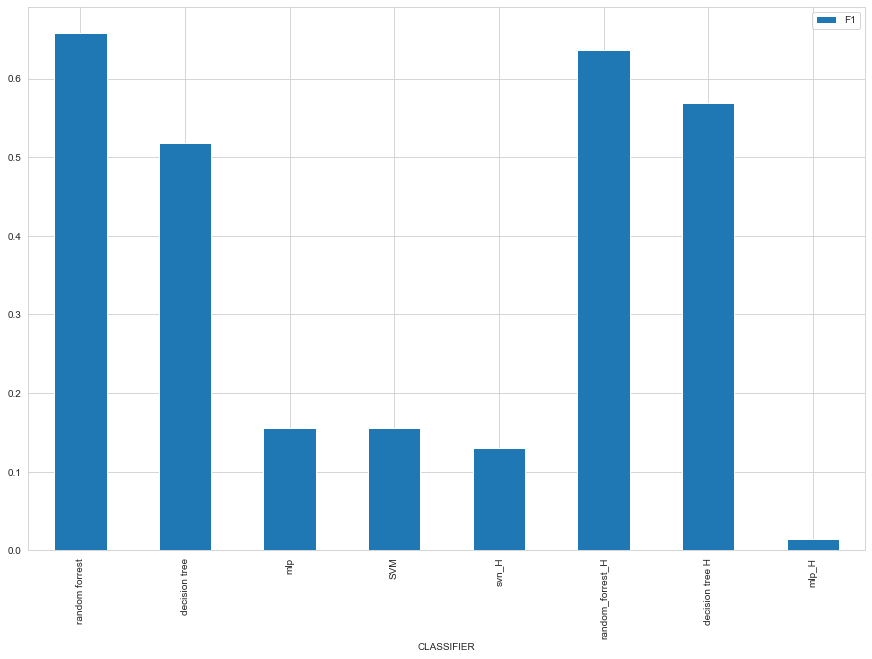

In [52]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(15,10))
hierarchical_results.plot.bar(ax=ax,x='CLASSIFIER')

## PART II - comparison of LCN, LCPL, LCPN, Big-Bang

In [470]:
results_dict={}

### LCPN

In [435]:
class LCPN_Node:
    def __init__(self, ident,classifier):
        self.ident=ident
        self.clf=classifier
        self.children=[]
        self.training_xs=[]
        self.training_ys=[]
        pass
    
    def append_children(self,children):
        self.children.extend(children)
        pass
    
    def get_child(self,ident):
        return [child for child in self.children if child.ident==ident][0]
    
    def propagate_training_set(self,xs,ys):
        pass
    
    
    def train_classifier(self):
        self.clf.fit(self.training_xs,self.training_ys)
        
    def predict(self,x):
        if len(self.children)==0:
            return self.ident
        else:
            child_ident=self.clf.predict(x)
            return self.get_child(child_ident).predict(x)
        

In [436]:
class LCPN:
    def __init__(self, classifier=DecisionTreeClassifier):
        self.clf=classifier
        self.root=None
        pass
    
    def fit(self,train_xs,train_ys):
        self.build_lcpn(train_ys)
        self.propagate_trainingset_lcpn(self.root,train_xs.values,train_ys.to_list())
        self.train_node_classifiers_lcpn(self.root)
    
    
    ### SHOULD BE IMPLEMENTED MORE GENERIC
    def build_lcpn(self,train_ys):
        unique_labels=list(set(train_ys.to_list()))
        root=LCPN_Node('root',self.clf(random_state=0)) 
        root_children=[label.split('/')[0] for label in  unique_labels]
        r_c=[LCPN_Node(elem,self.clf(random_state=0)) for elem in root_children]
        root.append_children(r_c)
        second_level_nodes=[label for label in  unique_labels if len(label.split('/')) >=2]
        for elem in second_level_nodes:
            parent=elem.rsplit('/', 1)[0]
            node=root.get_child(parent)
            node.append_children([LCPN_Node(elem,self.clf(random_state=0))])
        self.root=root
    
    def propagate_trainingset_lcpn(self,node,xs,ys):
        for child in node.children:
            child_xs=[]
            child_ys=[]
            for i in range(len(ys)):
                if ys[i].startswith(child.ident):
                    child_xs.append(xs[i])
                    child_ys.append(child.ident)
            node.training_xs.extend(child_xs)
            node.training_ys.extend(child_ys)
            self.propagate_trainingset_lcpn(child,xs,ys) 
            
    def train_node_classifiers_lcpn(self,node):
        if len(node.training_ys)>0:
            node.train_classifier()
            for child in node.children:
                self.train_node_classifiers_lcpn(child)
                
    def predict_all(self,test_xs):
        results=[]
        for elem in test_xs.values:
            results.append(self.root.predict([elem]))
        return results


In [471]:
lcpn=LCPN()
lcpn.fit(train_ds_x,train_ds_y)
predicted=lcpn.predict_all(test_ds_x)
f1=evaluate_h_f1(test_ds_y,predicted)
results_dict['LCPN']=f1
f1

0.4579710144927536

### LCPL - local classifier per level

In [430]:
class LCPL_Level:
    def __init__(self,classifier,level,last=False):
        self.clf=classifier
        self.nodes=[]
        self.training_xs=[]
        self.training_ys=[]
        self.last=last
        self.level=level
        self.next_level=None
        pass
    
    def append_next_level(self,level):
        self.next_level=level
    
    def append_nodes(self,nodes):
        self.nodes.extend(nodes)
        pass
    
    def get_node(self,ident):
        return [node for node in self.nodes if node.ident==ident][0]
        
    
    def train_classifier(self):
        self.clf.fit(self.training_xs,self.training_ys)
        
    def predict(self,x):
        if self.last:
            ident=self.clf.predict(x)[0]
            return ident.split('/')[self.level]
        else:
            ident=self.clf.predict(x)[0]
            return ident.split('/')[self.level]+'/'+self.next_level.predict(x)

In [431]:
class LCPL:
    def __init__(self, classifier=DecisionTreeClassifier):
        self.clf=classifier
        self.level_0=None
        pass
    
    def fit(self,train_xs,train_ys):
        self.build_lcpl(train_ys)
        self.propagate_trainingset_lcpl(self.level_0,train_xs.values,train_ys.to_list())
        self.train_level_classifiers_lcpl(self.level_0)
    
    def build_lcpl(self,train_ys):
        unique_labels=list(set(train_ys.to_list()))
        level_0=LCPL_Level(DecisionTreeClassifier(),0,False)
        level_0_nodes=[label.split('/')[0] for label in  unique_labels]
        level_0.append_nodes(level_0_nodes)
        level_1=LCPL_Level(DecisionTreeClassifier(),1,True)
        level_0.append_next_level(level_1)
        level_1_nodes=[label for label in  unique_labels if len(label.split('/')) >=2]
        level_1.append_nodes(level_1_nodes)
        self.level_0=level_0
    
    def propagate_trainingset_lcpl(self,level,xs,ys):
        if level !=None:
            for node in level.nodes:
                node_xs=[]
                node_ys=[]
                for i in range(len(ys)):
                    if ys[i].startswith(node):
                        node_xs.append(xs[i])
                        node_ys.append(node)
                level.training_xs.extend(node_xs)
                level.training_ys.extend(node_ys)
                self.propagate_trainingset_lcpl(level.next_level,xs,ys) 
                
    def train_level_classifiers_lcpl(self,level):
        if level != None:
            level.train_classifier()
            self.train_level_classifiers_lcpl(level.next_level)
            
    def predict_all(self,test_xs):
        results=[]
        for elem in test_xs.values:
            results.append(self.level_0.predict([elem]))
        return results
            

In [472]:
lcpl=LCPL()

In [473]:
lcpl.fit(train_ds_x,train_ds_y)
predicted=lcpl.predict_all(test_ds_x)
f1=evaluate_h_f1(test_ds_y,predicted)
results_dict['LCPL']=f1
f1

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['000/04', '000/07', '000/08', '000/106', '000/11', '000/115', '000/135', '000/157', '000/195', '000/213', '000/251', '000/265', '000/267', '000/269', '000/40', '000/49', '000/63', '000/68', '000/81', '000/82', '000/90', '000/95', '001/00', '001/02', '001/04', '001/101', '001/271', '001/49', '001/62', '001/72', '001/82', '001/95', '002/04', '002/07', '002/104', '002/106', '002/123', '002/131', '002/195', '002/213', '002/252', '002/30', '002/47', '002/54', '002/90', '002/94', '003/195', '003/40', '004/131', '004/213', '004/267', '004/268', '004/68', '004/82', '004/90', '006/10', '006/100', '006/106', '006/115', '006/181', '006/52', '006/70', '006/72', '006/95', '007/02', '007/07', '007/101', '007/131', '007/132', '007/152', '007/157', '007/47', '007/81', '007/90', '008/02', '008/07', '008/11', '008/115', '008/121', '008/123', '008/132', '008/157', '008/251', '008/272', '009/181', '0

0.4652631578947368

### LCN - local classifier per node

In [459]:
class LCN_Node:
    def __init__(self, ident):
        self.ident=ident
        self.clf=LogisticRegression(random_state=0)
        self.children=[]
        self.training_xs=[]
        self.training_ys=[]
        pass
    
    def append_children(self,children):
        self.children.extend(children)
        pass
    
    def get_child(self,ident):
        return [child for child in self.children if child.ident==ident][0]
    
    def train_classifier(self):
        self.clf.fit(self.training_xs,self.training_ys)
        
    def predict(self,x):
        if len(self.children)==0:
            return self.ident
        else:
            child_confidences=[child.clf.predict_proba(x)[0][1] for child in self.children]
            max_index = child_confidences.index(max(child_confidences))
            return self.children[max_index].predict(x)

In [460]:
class LCN:
    def __init__(self):
        self.root=None
        pass
    
    def fit(self,train_xs,train_ys):
        self.build_lcn(train_ys)
        self.propagate_trainingset_lcn(self.root,train_xs.values,train_ys.to_list())
        self.train_node_classifiers_lcn(self.root)
    
    
    ### SHOULD BE IMPLEMENTED MORE GENERIC
    def build_lcn(self,train_ys):
        unique_labels=list(set(train_ys.to_list()))
        root=LCN_Node('root') 
        root_children=[label.split('/')[0] for label in  unique_labels]
        r_c=[LCN_Node(elem) for elem in root_children]
        root.append_children(r_c)
        second_level_nodes=[label for label in  unique_labels if len(label.split('/')) >=2]
        for elem in second_level_nodes:
            parent=elem.rsplit('/', 1)[0]
            node=root.get_child(parent)
            node.append_children([LCN_Node(elem)])
        self.root=root
    
    def propagate_trainingset_lcn(self,node,xs,ys):
        for child in node.children:
            child_xs=[]
            child_ys=[]
            for i in range(len(ys)):
                if ys[i].startswith(child.ident):
                    child_xs.append(xs[i])
                    child_ys.append(1)
                else:
                    child_xs.append(xs[i])
                    child_ys.append(0)
            child.training_xs.extend(child_xs)
            child.training_ys.extend(child_ys)
            self.propagate_trainingset_lcn(child,xs,ys) 
            
    def train_node_classifiers_lcn(self,node):
        if node.ident== 'root':
            for child in node.children:
                train_node_classifiers_lcpn(child)
        if len(node.training_ys)>0:
            node.train_classifier()
            for child in node.children:
                self.train_node_classifiers_lcn(child)
                
    def predict_all(self,test_xs):
        results=[]
        for elem in test_xs.values:
            results.append(self.root.predict([elem]))
        return results

In [1]:
lcn=LCN()
lcn.fit(train_ds_x,train_ds_y)

In [476]:
predicted=lcn.predict_all(test_ds_x)

In [477]:
f1=evaluate_h_f1(test_ds_y,predicted)
results_dict['LCN']=f1
f1

0.6527075812274369

### Big bang classifier

In [478]:
unique_labels=list(set(train_ds_y.to_list()))
level_1_leafs=[label for label in  unique_labels if '/' not in label]
level_2_leafs=[label for label in  unique_labels if len(label.split('/')) ==2]
leafs=level_1_leafs+level_2_leafs
LEAFS_COUNT=len(leafs)

In [479]:
clf = DecisionTreeClassifier(random_state=0,max_leaf_nodes=LEAFS_COUNT)
clf.fit(train_ds_x,train_ds_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=71,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

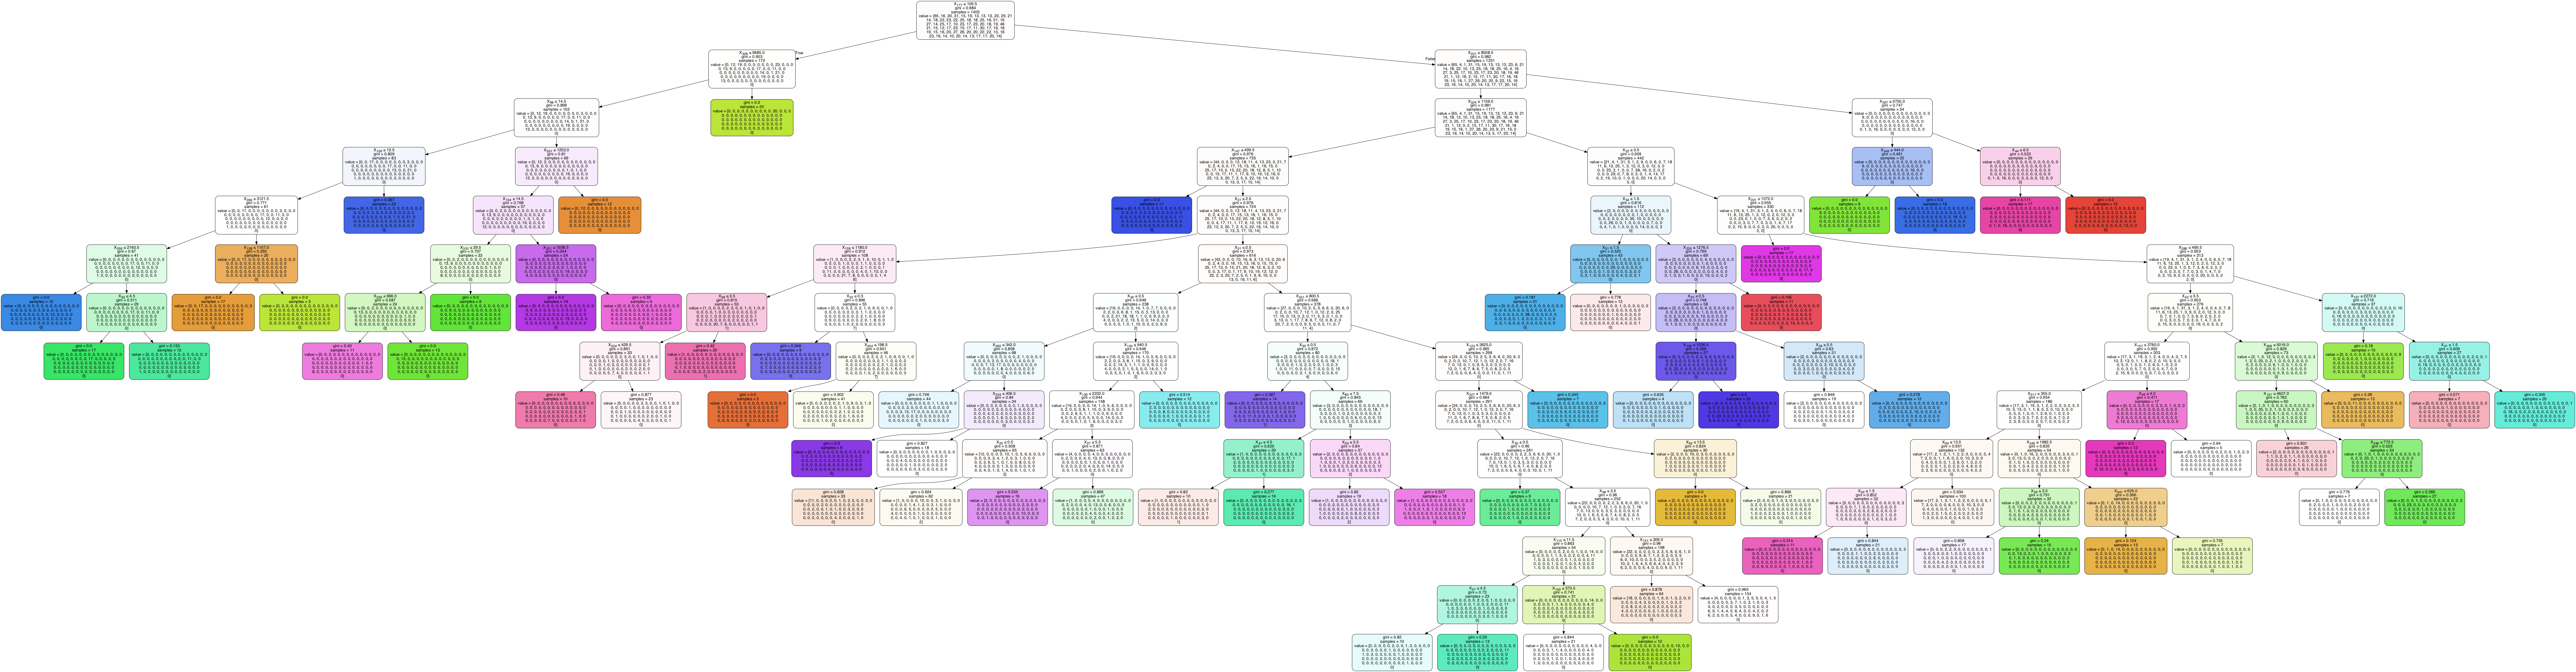

In [480]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [481]:
visualize_big_bang(clf)

In [482]:
res=clf.predict(test_ds_x)
f1=evaluate_h_f1(test_ds_y,res)
results_dict['Big Bang']=f1
f1

0.3879699248120301

In [483]:
results_dict

{'LCPN': 0.4579710144927536,
 'LCPL': 0.4652631578947368,
 'LCN': 0.6527075812274369,
 'Big Bang': 0.3879699248120301}

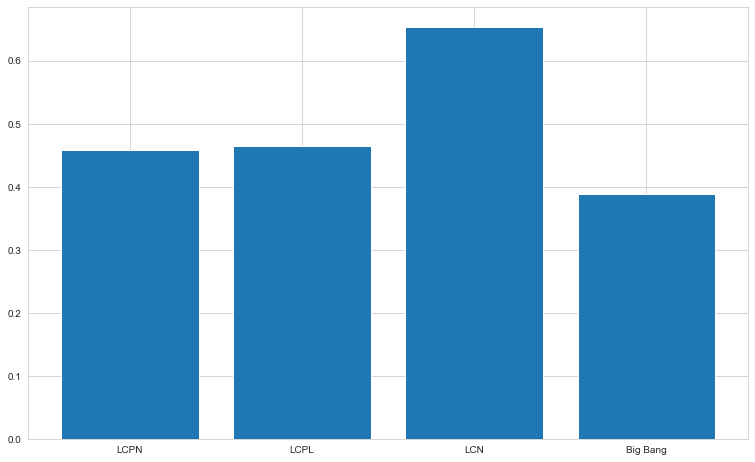

In [486]:
def plot_comparison_results(results_dict):
    keys=list(results_dict.keys())
    values=list(results_dict.values())
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(keys,values)
    plt.show()

plot_comparison_results(results_dict)

### Outcomes -  LCPN, LCN, LCPL, Big Bang 

#### LCPL
##### Drawbacks:
- at the next level relative to the given LCPL can make predictions of children not belonging to the node with the highest prediction at the given level
- learning samples are unblanaced
- many classes at a given level - worse quality of prediction
##### Pros:
- a small number of classifiers to learn - equal to the number of hierarchy levels
#### LCPN
##### Pros:
- intuitive, corresponds to common sense classification
##### Drawbacks:
- more classifiers from LCPL
#### LCN:
##### Pros:
- it's easy to extend it to multilabel classification 
##### Drawbacks:
- only limited classifiers can be used - those that return confidence in binary classification
- inconsistencies may be obtained with multi-label classification, e.g. simultaneous detection of a cat and a horse
- many local classifiers to learn = long learning time
#### Big Bang:
##### Pros:
- in the simplest case, you can base it on a decision tree 
##### Drawbacks:
- HC4.5 algorithm, hardly described in the literature, relatively difficult to implement